# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.linear_model import LogisticRegression as SklearnPenalizedLogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
import statsmodels.api as sm
from scipy.optimize import minimize, root, _numdiff
from scipy.linalg import inv, svd, cholesky, LinAlgError
from scipy.optimize import root
from scipy.stats import norm

# Prepare the Data

In [2]:
# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Sklearn LogReg

In [3]:
# Logistic Regression with scikit-learn
sklearn_model = SklearnLogisticRegression(solver='lbfgs')
sklearn_model.fit(X_train, y_train)
y_pred_sklearn = sklearn_model.predict(X_test)
y_pred_proba_sklearn = sklearn_model.predict_proba(X_test)[:, 1]
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
log_loss_sklearn = log_loss(y_test, y_pred_proba_sklearn)
print(f"Accuracy (scikit-learn): {accuracy_sklearn:.4f}")
print(f"Log Loss (scikit-learn): {log_loss_sklearn:.4f}")

Accuracy (scikit-learn): 0.8467
Log Loss (scikit-learn): 0.3566


# Statsmodels LogReg

In [4]:
# Logistic Regression with statsmodels
X_train_sm = sm.add_constant(X_train)  # Adding intercept term
X_test_sm = sm.add_constant(X_test)
statsmodels_model = sm.Logit(y_train, X_train_sm).fit()
y_pred_proba_sm = statsmodels_model.predict(X_test_sm)
y_pred_sm = (y_pred_proba_sm >= 0.5).astype(int)
accuracy_sm = accuracy_score(y_test, y_pred_sm)
log_loss_sm = log_loss(y_test, y_pred_proba_sm)
print(f"\nAccuracy (statsmodels): {accuracy_sm:.4f}")
print(f"Log Loss (statsmodels): {log_loss_sm:.4f}")

Optimization terminated successfully.
         Current function value: 0.322850
         Iterations 8

Accuracy (statsmodels): 0.8400
Log Loss (statsmodels): 0.3576


# Maximum Likelihood Estimation

In [5]:
class LogisticRegressionMLE:
    """
    Logistic Regression using Maximum Likelihood Estimation (MLE).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit(solver='BFGS'):
        Fits the logistic regression model using the specified solver.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """Computes the negative log-likelihood."""
        z = np.dot(self.X, beta)
        return -np.sum(self.y * z - np.log(1 + np.exp(z)))

    def fit(self, solver='BFGS'):
        """
        Fits the logistic regression model using the specified solver.

        Parameters:
        -----------
        solver : str, optional
            The optimization solver to use (default is 'BFGS').

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        initial_beta = np.zeros(self.X.shape[1])
        result = minimize(self.log_likelihood, initial_beta, method=solver)
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [6]:
# Maximum Likelihood Estimation
mle_model = LogisticRegressionMLE(X_train, y_train)
mle_model.fit(solver='BFGS')
accuracy_mle, log_loss_mle = mle_model.evaluate(X_test, y_test)
print(f"Accuracy (MLE): {accuracy_mle:.4f}")
print(f"Log Loss (MLE): {log_loss_mle:.4f}")

Accuracy (MLE): 0.8400
Log Loss (MLE): 0.3557


# Laplace Approximation

In [7]:
class LogisticRegressionLaplace:
    """
    Logistic Regression with Laplace Approximation for Bayesian inference.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    sigma : float
        The standard deviation of the prior.
    beta_map : np.ndarray
        The MAP estimate of coefficients after fitting the model.
    posterior_covariance : np.ndarray
        The covariance matrix of the posterior distribution.

    Methods:
    --------
    fit(solver='BFGS'):
        Fits the logistic regression model using Laplace Approximation.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    plot_posterior_distributions():
        Plots the posterior distributions of the first two coefficients.
    """

    def __init__(self, X, y, sigma=1.0):
        self.X = X
        self.y = y
        self.sigma = sigma
        self.beta_map = None
        self.posterior_covariance = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """Computes the negative log-likelihood."""
        z = np.dot(self.X, beta)
        return -np.sum(self.y * z - np.log(1 + np.exp(z)))

    def log_prior(self, beta):
        """Computes the log-prior (Gaussian prior)."""
        return -0.5 * np.sum(beta ** 2) / self.sigma ** 2

    def negative_log_posterior(self, beta):
        """Computes the negative log-posterior."""
        return self.log_likelihood(beta) - self.log_prior(beta)

    def jacobian(self, beta):
        """Computes the Jacobian (gradient) of the negative log-posterior."""
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        grad_log_likelihood = np.dot(self.X.T, (p - self.y))
        grad_log_prior = beta / self.sigma ** 2
        return grad_log_likelihood - grad_log_prior

    def fit(self, solver='BFGS'):
        """
        Fits the logistic regression model using Laplace Approximation.

        Parameters:
        -----------
        solver : str, optional
            The optimization solver to use (default is 'BFGS').
            Only solvers that provide the inverse Hessian are allowed.

        Returns:
        --------
        beta_map : np.ndarray
            The MAP estimate of coefficients.
        posterior_covariance : np.ndarray
            The covariance matrix of the posterior distribution.
        """
        if solver not in ['BFGS', 'L-BFGS-B', 'Newton-CG']:
            raise ValueError(f"Solver '{solver}' does not provide an inverse Hessian or requires a Jacobian. Please choose 'BFGS', 'L-BFGS-B', or 'Newton-CG'.")

        initial_beta = np.zeros(self.X.shape[1])

        if solver in ['BFGS', 'L-BFGS-B']:
            result = minimize(self.negative_log_posterior, initial_beta, method=solver)
            hessian_matrix = result.hess_inv if solver == 'BFGS' else result.hess_inv.todense()
        elif solver == 'Newton-CG':
            result = minimize(self.negative_log_posterior, initial_beta, method=solver, jac=self.jacobian)
            hessian_matrix = _numdiff.approx_derivative(self.jacobian, result.x, method='3-point')

        # Regularization and SVD to stabilize Hessian inversion
        eigenvalues, eigenvectors = np.linalg.eigh(hessian_matrix)
        epsilon = max(1e-5, abs(np.min(eigenvalues)) + 1e-5)
        hessian_matrix += np.eye(hessian_matrix.shape[0]) * epsilon

        # Use SVD for stable inversion
        U, s, Vt = svd(hessian_matrix)
        s_inv = np.array([1 / si if si > 1e-10 else 0 for si in s])
        hessian_inv = np.dot(Vt.T, np.dot(np.diag(s_inv), U.T))

        self.posterior_covariance = hessian_inv
        self.beta_map = result.x
        return self.beta_map, self.posterior_covariance

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta_map)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

    def plot_posterior_distributions(self):
        """Plots the posterior distributions of the first two coefficients."""
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        for i in range(2):  # Show first two coefficients for simplicity
            mean = self.beta_map[i]
            std = np.sqrt(self.posterior_covariance[i, i])
            if np.isnan(std):  # Check if std is NaN
                axes[i].text(0.5, 0.5, 'Invalid Covariance', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            else:
                x = np.linspace(mean - 3 * std, mean + 3 * std, 100)
                y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
                axes[i].plot(x, y)
            axes[i].set_title(f'Posterior Distribution of Coefficient {i + 1}')
        plt.tight_layout()
        plt.show()

Accuracy (Laplace): 0.8400
Log Loss (Laplace): 0.3562



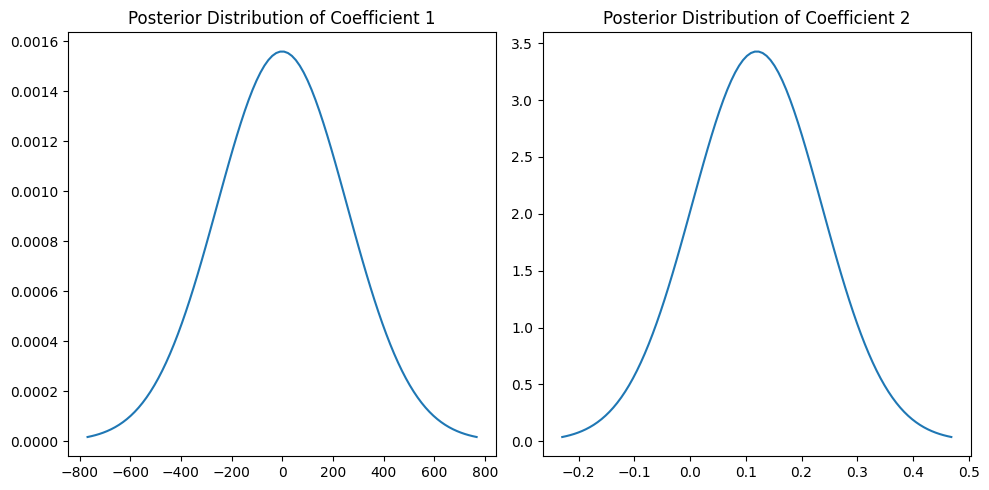

In [8]:
# Laplace Approximation
laplace_model = LogisticRegressionLaplace(X_train, y_train)
laplace_model.fit(solver='Newton-CG')
accuracy_laplace, log_loss_laplace = laplace_model.evaluate(X_test, y_test)
print(f"Accuracy (Laplace): {accuracy_laplace:.4f}")
print(f"Log Loss (Laplace): {log_loss_laplace:.4f}\n")

# Visualize Posterior Distributions from Laplace Approximation
laplace_model.plot_posterior_distributions()

# Generalized Method of Moments

In [9]:
class LogisticRegressionGMM:
    """
    Logistic Regression using Generalized Method of Moments (GMM).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using GMM.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def moment_conditions(self, beta):
        """Defines the moment conditions for GMM."""
        probabilities = self.sigmoid(np.dot(self.X, beta))
        moments = np.dot(self.X.T, self.y - probabilities)
        return moments

    def fit(self):
        """
        Fits the logistic regression model using GMM.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        initial_beta = np.zeros(self.X.shape[1])
        result = root(self.moment_conditions, initial_beta, method='hybr')
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [10]:
# Generalized Method of Moments
gmm_model = LogisticRegressionGMM(X_train, y_train)
gmm_model.fit()
accuracy_gmm, log_loss_gmm = gmm_model.evaluate(X_test, y_test)
print(f"Accuracy (GMM): {accuracy_gmm:.4f}")
print(f"Log Loss (GMM): {log_loss_gmm:.4f}")

Accuracy (GMM): 0.8400
Log Loss (GMM): 0.3557


# Quasi-Likelihood Estimation

In [11]:
class LogisticRegressionQLE:
    """
    Logistic Regression using Quasi-Likelihood Estimation (QLE).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using QLE.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def quasi_likelihood(self, beta):
        """
        Defines the quasi-likelihood function.
        This can be modified based on the specific quasi-likelihood being used.
        """
        probabilities = self.sigmoid(np.dot(self.X, beta))

        # Quasi-likelihood function
        return -np.sum(self.y * np.log(probabilities) + (1 - self.y) * np.log(1 - probabilities))

    def fit(self):
        """
        Fits the logistic regression model using QLE.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        initial_beta = np.zeros(self.X.shape[1])
        result = minimize(self.quasi_likelihood, initial_beta, method='BFGS')
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [12]:
# Quasi-Likelihood Estimation
qle_model = LogisticRegressionQLE(X_train, y_train)
qle_model.fit()
accuracy_qle, log_loss_qle = qle_model.evaluate(X_test, y_test)
print(f"Accuracy (QLE): {accuracy_qle:.4f}")
print(f"Log Loss (QLE): {log_loss_qle:.4f}")

Accuracy (QLE): 0.8400
Log Loss (QLE): 0.3557


# LogitBoost

In [13]:
class LogisticRegressionLogitBoost:
    """
    Logistic Regression using LogitBoost.

    Attributes:
    -----------
    model : AdaBoostClassifier
        The LogitBoost model (AdaBoost with decision stumps as weak learners).

    Methods:
    --------
    fit():
        Fits the LogitBoost model to the training data.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, n_estimators=50):
        self.model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_estimators,
            algorithm='SAMME.R'
        )

    def fit(self, X, y):
        """
        Fits the LogitBoost model to the training data.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        self.model.fit(X, y)

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        return self.model.predict_proba(X_new)[:, 1]

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return self.model.predict(X_new)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [14]:
# LogitBoost
logitboost_model = LogisticRegressionLogitBoost(n_estimators=50)
logitboost_model.fit(X_train, y_train)
accuracy_logitboost, log_loss_logitboost = logitboost_model.evaluate(X_test, y_test)
print(f"Accuracy (LogitBoost): {accuracy_logitboost:.4f}")
print(f"Log Loss (LogitBoost): {log_loss_logitboost:.4f}")

Accuracy (LogitBoost): 0.8633
Log Loss (LogitBoost): 0.6291


# Empirical Likelihood

In [15]:
class LogisticRegressionEL:
    """
    Logistic Regression using Empirical Likelihood (EL).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using EL.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def el_objective(self, beta):
        """
        Objective function for Empirical Likelihood.
        It maximizes the empirical likelihood subject to constraints.
        """
        probabilities = self.sigmoid(np.dot(self.X, beta))
        log_weights = np.log(probabilities * self.y + (1 - probabilities) * (1 - self.y))
        return -np.sum(log_weights)

    def fit(self):
        """
        Fits the logistic regression model using Empirical Likelihood.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        initial_beta = np.zeros(self.X.shape[1])
        result = minimize(self.el_objective, initial_beta, method='BFGS')
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [16]:
# Empirical Likelihood
el_model = LogisticRegressionEL(X_train, y_train)
el_model.fit()
accuracy_el, log_loss_el = el_model.evaluate(X_test, y_test)
print(f"Accuracy (EL): {accuracy_el:.4f}")
print(f"Log Loss (EL): {log_loss_el:.4f}")

Accuracy (EL): 0.8400
Log Loss (EL): 0.3557


# Pseudo-Likelihood

In [17]:
class LogisticRegressionPseudolikelihood:
    """
    Logistic Regression using Pseudolikelihood.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using the pseudolikelihood approach.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def pseudolikelihood(self, beta):
        """
        Computes the pseudolikelihood function.
        Approximates the full likelihood by considering individual conditional probabilities.
        """
        probabilities = self.sigmoid(np.dot(self.X, beta))
        pseudo_log_likelihood = np.sum(self.y * np.log(probabilities) + (1 - self.y) * np.log(1 - probabilities))
        return -pseudo_log_likelihood

    def fit(self):
        """
        Fits the logistic regression model using the pseudolikelihood approach.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        initial_beta = np.zeros(self.X.shape[1])
        result = minimize(self.pseudolikelihood, initial_beta, method='BFGS')
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [18]:
# Pseudo-Likelihood
pl_model = LogisticRegressionPseudolikelihood(X_train, y_train)
pl_model.fit()
accuracy_pl, log_loss_pl = pl_model.evaluate(X_test, y_test)
print(f"Accuracy (Pseudo-likelihood): {accuracy_pl:.4f}")
print(f"Log Loss (Pseudo-likelihood): {log_loss_pl:.4f}")

Accuracy (Pseudo-likelihood): 0.8400
Log Loss (Pseudo-likelihood): 0.3557


# Penalized Likelihood

In [19]:
class LogisticRegressionPenalized:
    """
    Logistic Regression using Penalized Likelihood (L1, L2, or Elastic Net).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    penalty : str
        The type of penalty ('l1', 'l2', or 'elasticnet').
    alpha : float
        The regularization strength.
    l1_ratio : float
        The mixing parameter for Elastic Net (used only if penalty is 'elasticnet').
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using the specified penalized likelihood.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y, penalty='l2', alpha=1.0, l1_ratio=0.5):
        self.X = X
        self.y = y
        self.penalty = penalty
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.beta = None

    def fit(self):
        """
        Fits the logistic regression model using the specified penalized likelihood.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        model = SklearnPenalizedLogisticRegression(
            penalty=self.penalty,
            C=1.0/self.alpha,
            solver='saga',
            l1_ratio=self.l1_ratio if self.penalty == 'elasticnet' else None,
            max_iter=10000
        )
        model.fit(self.X, self.y)
        self.beta = model.coef_
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        model = SklearnPenalizedLogisticRegression(
            penalty=self.penalty,
            C=1.0/self.alpha,
            solver='saga',
            l1_ratio=self.l1_ratio if self.penalty == 'elasticnet' else None,
            max_iter=10000
        )
        model.fit(self.X, self.y)
        return model.predict_proba(X_new)[:, 1]

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [20]:
# Penalized Likelihood
penalized_model = LogisticRegressionPenalized(X_train, y_train, penalty='elasticnet', alpha=0.1, l1_ratio=0.5)
penalized_model.fit()
accuracy_penalized, log_loss_penalized = penalized_model.evaluate(X_test, y_test)
print(f"Accuracy (Penalized Likelihood): {accuracy_penalized:.4f}")
print(f"Log Loss (Penalized Likelihood): {log_loss_penalized:.4f}")

Accuracy (Penalized Likelihood): 0.8433
Log Loss (Penalized Likelihood): 0.3575


# Markov Chain Monte Carlo

In [21]:
!pip install -q pymc

In [22]:
import pymc as pm
from scipy.special import expit

class LogisticRegressionMCMC:
    """
    Logistic Regression using Markov Chain Monte Carlo (MCMC) for Bayesian inference.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    trace : pm.backends.base.MultiTrace or None
        The trace of the sampled posterior distribution.

    Methods:
    --------
    fit():
        Fits the logistic regression model using MCMC.
    predict_proba(X_new):
        Predicts probabilities for new data based on posterior samples.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        """
        Initializes the LogisticRegressionMCMC class with the feature matrix and target vector.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        self.X = X
        self.y = y
        self.trace = None

    def fit(self):
        """
        Fits the logistic regression model using MCMC.

        Returns:
        --------
        trace : pm.backends.base.MultiTrace
            The trace of the sampled posterior distribution.
        """
        with pm.Model() as logistic_model:
            # Priors for the coefficients
            beta = pm.Normal('beta', mu=0, sigma=10, shape=self.X.shape[1])
            intercept = pm.Normal('intercept', mu=0, sigma=10)

            # Logistic regression model
            p = pm.math.sigmoid(pm.math.dot(self.X, beta) + intercept)
            likelihood = pm.Bernoulli('y', p=p, observed=self.y)

            # Sampling from the posterior
            self.trace = pm.sample(1000, tune=1000, return_inferencedata=False, cores=1)

        return self.trace

    def predict_proba(self, X_new):
        """
        Predicts probabilities for new data based on posterior samples.

        Parameters:
        -----------
        X_new : np.ndarray
            New data for which to predict probabilities.

        Returns:
        --------
        p_mean : np.ndarray
            Predicted probabilities for each sample in X_new.
        """
        try:
            beta_samples = self.trace['beta']
            intercept_samples = self.trace['intercept']

            print("Debugging shapes:")
            print(f"X_new shape: {X_new.shape}")
            print(f"beta_samples shape: {beta_samples.shape}")
            print(f"intercept_samples shape: {intercept_samples.shape}")

            # Compute the mean of the predicted probabilities across samples
            p_samples = expit(np.dot(X_new, beta_samples.T) + intercept_samples)

            print("p_samples shape:", p_samples.shape)
            p_mean = np.mean(p_samples, axis=1)  # Compute the mean across the samples (axis=1)

            return p_mean

        except Exception as e:
            print(f"Error during probability prediction: {e}")
            raise

    def predict(self, X_new):
        """
        Predicts binary class labels for new data.

        Parameters:
        -----------
        X_new : np.ndarray
            New data for which to predict binary class labels.

        Returns:
        --------
        np.ndarray
            Predicted binary class labels (0 or 1) for each sample in X_new.
        """
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            Test data for which to evaluate the model.
        y_test : np.ndarray
            True labels for the test data.

        Returns:
        --------
        accuracy : float
            Accuracy of the model on the test data.
        log_loss_val : float
            Log loss of the model on the test data.
        """
        try:
            y_pred_proba = self.predict_proba(X_test)
            y_pred = self.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            log_loss_val = log_loss(y_test, y_pred_proba)
            return accuracy, log_loss_val

        except Exception as e:
            print(f"Error during evaluation: {e}")
            raise

In [23]:
# Markov Chain Monte Carlo
mcmc_model = LogisticRegressionMCMC(X_train, y_train)
mcmc_model.fit()
accuracy_mcmc, log_loss_mcmc = mcmc_model.evaluate(X_test, y_test)
print(f"\nAccuracy (MCMC): {accuracy_mcmc:.4f}")
print(f"Log Loss (MCMC): {log_loss_mcmc:.4f}")

Debugging shapes:
X_new shape: (300, 10)
beta_samples shape: (2000, 10)
intercept_samples shape: (2000,)
p_samples shape: (300, 2000)
Debugging shapes:
X_new shape: (300, 10)
beta_samples shape: (2000, 10)
intercept_samples shape: (2000,)
p_samples shape: (300, 2000)

Accuracy (MCMC): 0.8400
Log Loss (MCMC): 0.3577


# Variational Inference

In [24]:
import pymc as pm
from scipy.special import expit

class LogisticRegressionVariationalInference:
    """
    Logistic Regression using Variational Inference (VI) for Bayesian inference.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    approx : pm.Approximation or None
        The approximation of the posterior distribution using variational inference.

    Methods:
    --------
    fit():
        Fits the logistic regression model using VI.
    predict_proba(X_new):
        Predicts probabilities for new data based on the VI approximation.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y):
        """
        Initializes the LogisticRegressionVariationalInference class with the feature matrix and target vector.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        self.X = X
        self.y = y
        self.approx = None

    def fit(self):
        """
        Fits the logistic regression model using Variational Inference.

        Returns:
        --------
        approx : pm.Approximation
            The approximation of the posterior distribution using VI.
        """
        with pm.Model() as logistic_model:
            # Priors for the coefficients
            beta = pm.Normal('beta', mu=0, sigma=10, shape=self.X.shape[1])
            intercept = pm.Normal('intercept', mu=0, sigma=10)

            # Logistic regression model
            p = pm.math.sigmoid(pm.math.dot(self.X, beta) + intercept)
            likelihood = pm.Bernoulli('y', p=p, observed=self.y)

            # Variational inference approximation
            self.approx = pm.fit(10000, method='advi')

        return self.approx

    def predict_proba(self, X_new):
        """
        Predicts probabilities for new data based on the VI approximation.

        Parameters:
        -----------
        X_new : np.ndarray
            New data for which to predict probabilities.

        Returns:
        --------
        p_mean : np.ndarray or None
            Predicted probabilities for each sample in X_new. Returns None if an error occurs.
        """
        try:
            posterior = self.approx.sample(1000)

            # Access the posterior samples from the InferenceData object
            beta_samples = np.squeeze(posterior.posterior['beta'].values)
            intercept_samples = np.squeeze(posterior.posterior['intercept'].values)

            print(f"X_new shape: {X_new.shape}")
            print(f"beta_samples shape: {beta_samples.shape}")
            print(f"intercept_samples shape: {intercept_samples.shape}")

            # Compute the mean of the predicted probabilities across samples
            p_samples = expit(np.dot(X_new, beta_samples.T) + intercept_samples)

            print(f"p_samples shape: {p_samples.shape}")

            p_mean = np.mean(p_samples, axis=1)
            return p_mean

        except Exception as e:
            print(f"Error during probability prediction: {e}")
            return None

    def predict(self, X_new):
        """
        Predicts binary class labels for new data.

        Parameters:
        -----------
        X_new : np.ndarray
            New data for which to predict binary class labels.

        Returns:
        --------
        np.ndarray or None
            Predicted binary class labels (0 or 1) for each sample in X_new. Returns None if an error occurs.
        """
        proba = self.predict_proba(X_new)
        if proba is not None:
            return (proba >= 0.5).astype(int)
        else:
            return None

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            Test data for which to evaluate the model.
        y_test : np.ndarray
            True labels for the test data.

        Returns:
        --------
        accuracy : float or None
            Accuracy of the model on the test data. Returns None if an error occurs.
        log_loss_val : float or None
            Log loss of the model on the test data. Returns None if an error occurs.
        """
        try:
            y_pred_proba = self.predict_proba(X_test)
            if y_pred_proba is None:
                raise ValueError("Probability prediction failed.")

            y_pred = self.predict(X_test)
            if y_pred is None:
                raise ValueError("Label prediction failed.")

            accuracy = accuracy_score(y_test, y_pred)
            log_loss_val = log_loss(y_test, y_pred_proba)
            return accuracy, log_loss_val
        except Exception as e:
            print(f"Error during evaluation: {e}")
            return None, None

In [25]:
# Variational Inference
vi_model = LogisticRegressionVariationalInference(X_train, y_train)
vi_model.fit()
accuracy_vi, log_loss_vi = vi_model.evaluate(X_test, y_test)
print(f"\nAccuracy (VI): {accuracy_vi:.4f}")
print(f"Log Loss (VI): {log_loss_vi:.4f}")

X_new shape: (300, 10)
beta_samples shape: (1000, 10)
intercept_samples shape: (1000,)
p_samples shape: (300, 1000)
X_new shape: (300, 10)
beta_samples shape: (1000, 10)
intercept_samples shape: (1000,)
p_samples shape: (300, 1000)

Accuracy (VI): 0.8467
Log Loss (VI): 0.3577


# Iteratively Re-Weighted

In [26]:
class LogisticRegressionIRLS:
    """
    Logistic Regression using Iteratively Reweighted Least Squares (IRLS).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using IRLS.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y, tol=1e-6, max_iter=100, lambda_=0.01):
        self.X = X
        self.y = y
        self.tol = tol
        self.max_iter = max_iter
        self.lambda_ = lambda_  # Regularization parameter
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        z = np.clip(z, -500, 500)  # Clip z to avoid overflow in exp
        return 1 / (1 + np.exp(-z))

    def fit(self):
        """
        Fits the logistic regression model using IRLS.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_samples, n_features = self.X.shape
        X = np.c_[np.ones(n_samples), self.X]  # Add intercept term
        self.beta = np.zeros(X.shape[1])  # Initialize beta with the correct size

        I = np.eye(X.shape[1])  # Identity matrix for regularization

        for _ in range(self.max_iter):
            beta_old = self.beta.copy()
            p = self.sigmoid(np.dot(X, self.beta))
            W = np.diag(p * (1 - p))  # Weight matrix

            # Add ridge regularization to avoid singular matrix
            XTWX = np.dot(X.T, np.dot(W, X)) + self.lambda_ * I
            XTWy = np.dot(X.T, np.dot(W, np.dot(X, self.beta) + np.linalg.inv(W).dot(self.y - p)))
            self.beta = np.linalg.solve(XTWX, XTWy)

            # Check for convergence
            if np.linalg.norm(self.beta - beta_old, ord=1) < self.tol:
                break

        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        X_new = np.c_[np.ones(X_new.shape[0]), X_new]  # Add intercept term
        return self.sigmoid(np.dot(X_new, self.beta))

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [27]:
# Iteratively Re-weighted algorithm
irls_model = LogisticRegressionIRLS(X_train, y_train)
irls_model.fit()
accuracy_irls, log_loss_irls = irls_model.evaluate(X_test, y_test)
print(f"Accuracy (IRLS): {accuracy_irls:.4f}")
print(f"Log Loss (IRLS): {log_loss_irls:.4f}")

Accuracy (IRLS): 0.8400
Log Loss (IRLS): 0.3576


# Modified Maximum Likelihood

In [28]:
class LogisticRegressionTikuMML:
    """
    Logistic Regression using Tiku's Modified Maximum Likelihood (MML).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using Tiku's MML.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y, tol=1e-6, max_iter=100):
        self.X = X
        self.y = y
        self.tol = tol
        self.max_iter = max_iter
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def modified_log_likelihood(self, beta):
        """
        Computes the modified log-likelihood function.
        This includes a robustness modification based on Tiku's method.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)

        # Adding a small constant to prevent overflow/underflow
        epsilon = 1e-8
        p = np.clip(p, epsilon, 1 - epsilon)

        # Modified log-likelihood function
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p)) + np.sum(np.abs(beta))

    def fit(self):
        """
        Fits the logistic regression model using Tiku's MML.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        initial_beta = np.zeros(self.X.shape[1])
        result = minimize(self.modified_log_likelihood, initial_beta, method='BFGS')
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [29]:
# Tiku's Modified Maximum Likelihood
tiku_mml_model = LogisticRegressionTikuMML(X_train, y_train)
tiku_mml_model.fit()
accuracy_tiku_mml, log_loss_tiku_mml = tiku_mml_model.evaluate(X_test, y_test)
print(f"Accuracy (Tiku's MML): {accuracy_tiku_mml:.4f}")
print(f"Log Loss (Tiku's MML): {log_loss_tiku_mml:.4f}")

Accuracy (Tiku's MML): 0.8433
Log Loss (Tiku's MML): 0.3545


# Nested Pseudo-MLE

In [30]:
class LogisticRegressionNPML:
    """
    Logistic Regression using Nested Pseudo Maximum Likelihood (NPML).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using Nested Pseudo Maximum Likelihood.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y, tol=1e-6, max_iter=100):
        self.X = X
        self.y = y
        self.tol = tol
        self.max_iter = max_iter
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def nested_log_likelihood(self, beta_subset, subset):
        """
        Computes the nested log-likelihood function for a subset of parameters.
        """
        # Create a full beta vector with the current subset
        beta = self.beta.copy()
        beta[subset] = beta_subset

        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def fit(self):
        """
        Fits the logistic regression model using Nested Pseudo Maximum Likelihood.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]
        self.beta = np.zeros(n_features)

        # Split the feature indices into two subsets
        subset1 = np.arange(0, n_features // 2)
        subset2 = np.arange(n_features // 2, n_features)

        for _ in range(self.max_iter):
            # Optimize over the first subset of parameters
            result1 = minimize(self.nested_log_likelihood, self.beta[subset1], args=(subset1,), method='BFGS')
            self.beta[subset1] = result1.x

            # Optimize over the second subset of parameters
            result2 = minimize(self.nested_log_likelihood, self.beta[subset2], args=(subset2,), method='BFGS')
            self.beta[subset2] = result2.x

            # Check for convergence
            if np.linalg.norm(result1.x - self.beta[subset1], ord=1) < self.tol and \
               np.linalg.norm(result2.x - self.beta[subset2], ord=1) < self.tol:
                break

        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [31]:
# Nested Pseudo Maximum Likelihood (NPML)
npml_model = LogisticRegressionNPML(X_train, y_train)
npml_model.fit()
accuracy_npml, log_loss_npml = npml_model.evaluate(X_test, y_test)
print(f"Accuracy (NPML): {accuracy_npml:.4f}")
print(f"Log Loss (NPML): {log_loss_npml:.4f}")

Accuracy (NPML): 0.8400
Log Loss (NPML): 0.3551


# Satterthwaite

In [32]:
class LogisticRegressionSatterthwaiteMLE:
    """
    Logistic Regression using Satterthwaite-Adjusted Maximum Likelihood Estimation.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    confidence_intervals : np.ndarray
        Confidence intervals for the estimated coefficients.

    Methods:
    --------
    fit():
        Fits the logistic regression model using Satterthwaite-Adjusted MLE.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    compute_confidence_intervals():
        Computes Satterthwaite-adjusted confidence intervals for the estimated coefficients.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None
        self.confidence_intervals = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """
        Computes the negative log-likelihood function.
        This is the objective function to be minimized.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def compute_satterthwaite_adjustment(self, beta):
        """Computes Satterthwaite adjustment to standard errors."""
        p = self.sigmoid(np.dot(self.X, beta))
        W = np.diag(p * (1 - p))
        hessian = np.dot(self.X.T, np.dot(W, self.X))

        # Add regularization to ensure the Hessian is positive definite
        epsilon = 1e-5
        hessian += np.eye(hessian.shape[0]) * epsilon

        try:
            hessian_inv = np.linalg.inv(hessian)
            se = np.sqrt(np.diag(hessian_inv))
        except np.linalg.LinAlgError:
            # If inversion fails, return NaNs to signal a problem
            se = np.full(self.X.shape[1], np.nan)

        # Satterthwaite adjustment
        adjustment = 1 + (np.trace(hessian_inv @ hessian) / (2 * len(self.y)))
        adjusted_se = se * adjustment

        return adjusted_se

    def compute_confidence_intervals(self, beta):
        """Computes Satterthwaite-adjusted confidence intervals for the estimated coefficients."""
        adjusted_se = self.compute_satterthwaite_adjustment(beta)
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        lower_bound = beta - z_score * adjusted_se
        upper_bound = beta + z_score * adjusted_se
        return np.vstack((lower_bound, upper_bound)).T

    def fit(self):
        """
        Fits the logistic regression model using Satterthwaite-Adjusted MLE.
        """
        n_features = self.X.shape[1]
        initial_beta = np.zeros(n_features)

        result = minimize(self.log_likelihood, initial_beta, method='BFGS')
        self.beta = result.x
        self.confidence_intervals = self.compute_confidence_intervals(self.beta)
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [33]:
# Satterthwaite-Adjusted MLE
satterthwaite_mle_model = LogisticRegressionSatterthwaiteMLE(X_train, y_train)
satterthwaite_mle_model.fit()
accuracy_satterthwaite_mle, log_loss_satterthwaite_mle = satterthwaite_mle_model.evaluate(X_test, y_test)
print(f"Accuracy (Satterthwaite-MLE): {accuracy_satterthwaite_mle:.4f}")
print(f"Log Loss (Satterthwaite-MLE): {log_loss_satterthwaite_mle:.4f}")

Accuracy (Satterthwaite-MLE): 0.8400
Log Loss (Satterthwaite-MLE): 0.3557


# Genetic Algorithm

In [34]:
!pip install -q deap

In [35]:
from deap import base, creator, tools, algorithms

class LogisticRegressionGeneticAlgorithm:
    """
    Logistic Regression using Maximum Likelihood Estimation optimized via Genetic Algorithm.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    confidence_intervals : np.ndarray
        Confidence intervals for the estimated coefficients.

    Methods:
    --------
    fit():
        Fits the logistic regression model using MLE optimized via Genetic Algorithm.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    compute_confidence_intervals():
        Computes confidence intervals for the estimated coefficients.
    """

    def __init__(self, X, y, population_size=50, generations=100, cxpb=0.5, mutpb=0.2, elitism=True):
        self.X = X
        self.y = y
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb  # Crossover probability
        self.mutpb = mutpb  # Mutation probability
        self.elitism = elitism  # Whether to apply elitism
        self.beta = None
        self.confidence_intervals = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """
        Computes the negative log-likelihood function.
        This is the objective function to be minimized.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def compute_confidence_intervals(self, beta):
        """Computes confidence intervals for the estimated coefficients."""
        p = self.sigmoid(np.dot(self.X, beta))
        W = np.diag(p * (1 - p))
        hessian = np.dot(self.X.T, np.dot(W, self.X))

        # Regularize Hessian to ensure it's invertible
        epsilon = 1e-5
        hessian += np.eye(hessian.shape[0]) * epsilon

        try:
            hessian_inv = np.linalg.inv(hessian)
            se = np.sqrt(np.diag(hessian_inv))
        except np.linalg.LinAlgError:
            se = np.full(self.X.shape[1], np.nan)  # Handle singular matrix

        z_score = norm.ppf(0.975)  # For 95% confidence interval
        lower_bound = beta - z_score * se
        upper_bound = beta + z_score * se
        return np.vstack((lower_bound, upper_bound)).T

    def fit(self):
        """
        Fits the logistic regression model using MLE optimized via Genetic Algorithm.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]

        # Check if classes already exist and delete them if they do
        if hasattr(creator, "FitnessMin"):
            del creator.FitnessMin
        if hasattr(creator, "Individual"):
            del creator.Individual

        # Define the fitness function
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, -10, 10)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def eval_fitness(individual):
            log_lik = self.log_likelihood(np.array(individual))
            ci = self.compute_confidence_intervals(np.array(individual))
            ci_width = np.mean(ci[:, 1] - ci[:, 0])
            return log_lik + 0.01 * ci_width,  # Penalize wide confidence intervals

        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", eval_fitness)

        pop = toolbox.population(n=self.population_size)

        if self.elitism:
            hof = tools.HallOfFame(1, similar=np.array_equal)  # Use np.array_equal to compare individuals
            algorithms.eaSimple(pop, toolbox, cxpb=self.cxpb, mutpb=self.mutpb, ngen=self.generations,
                                halloffame=hof, verbose=False)
            best_individual = hof[0]
        else:
            algorithms.eaSimple(pop, toolbox, cxpb=self.cxpb, mutpb=self.mutpb, ngen=self.generations, verbose=False)
            best_individual = tools.selBest(pop, 1)[0]

        self.beta = np.array(best_individual)
        self.confidence_intervals = self.compute_confidence_intervals(self.beta)
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [36]:
# Genetic Algorithm MLE
ga_mle_model = LogisticRegressionGeneticAlgorithm(X_train, y_train)
ga_mle_model.fit()
accuracy_ga_mle, log_loss_ga_mle = ga_mle_model.evaluate(X_test, y_test)
print(f"Accuracy (GA-MLE): {accuracy_ga_mle:.4f}")
print(f"Log Loss (GA-MLE): {log_loss_ga_mle:.4f}")

Accuracy (GA-MLE): 0.8367
Log Loss (GA-MLE): 0.3556


# Nelder Mead

In [37]:
class LogisticRegressionNelderMead:
    """
    Logistic Regression using Maximum Likelihood Estimation optimized via Nelder-Mead Algorithm.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    confidence_intervals : np.ndarray
        Confidence intervals for the estimated coefficients.

    Methods:
    --------
    fit():
        Fits the logistic regression model using MLE optimized via Nelder-Mead Algorithm.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    compute_confidence_intervals():
        Computes confidence intervals for the estimated coefficients.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None
        self.confidence_intervals = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """
        Computes the negative log-likelihood function.
        This is the objective function to be minimized.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def compute_confidence_intervals(self, beta):
        """Computes confidence intervals for the estimated coefficients."""
        p = self.sigmoid(np.dot(self.X, beta))
        W = np.diag(p * (1 - p))
        hessian = np.dot(self.X.T, np.dot(W, self.X))

        # Regularize Hessian to ensure it's invertible
        epsilon = 1e-5
        hessian += np.eye(hessian.shape[0]) * epsilon

        try:
            hessian_inv = np.linalg.inv(hessian)
            se = np.sqrt(np.diag(hessian_inv))
        except np.linalg.LinAlgError:
            se = np.full(self.X.shape[1], np.nan)  # Handle singular matrix

        z_score = norm.ppf(0.975)  # For 95% confidence interval
        lower_bound = beta - z_score * se
        upper_bound = beta + z_score * se
        return np.vstack((lower_bound, upper_bound)).T

    def fit(self):
        """
        Fits the logistic regression model using MLE optimized via Nelder-Mead Algorithm.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]
        initial_beta = np.zeros(n_features)

        def objective_function(beta):
            return self.log_likelihood(beta)

        # Use Nelder-Mead algorithm for optimization
        result = minimize(objective_function, initial_beta, method='Nelder-Mead')
        self.beta = result.x
        self.confidence_intervals = self.compute_confidence_intervals(self.beta)
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [38]:
# Nelder-Mead MLE
nm_mle_model = LogisticRegressionNelderMead(X_train, y_train)
nm_mle_model.fit()
accuracy_nm_mle, log_loss_nm_mle = nm_mle_model.evaluate(X_test, y_test)
print(f"Accuracy (NM-MLE): {accuracy_nm_mle:.4f}")
print(f"Log Loss (NM-MLE): {log_loss_nm_mle:.4f}")

Accuracy (NM-MLE): 0.8333
Log Loss (NM-MLE): 0.3563


# Simulated Annealing

In [39]:
from scipy.optimize import dual_annealing

class LogisticRegressionSimulatedAnnealing:
    """
    Logistic Regression using Maximum Likelihood Estimation optimized via Simulated Annealing.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    confidence_intervals : np.ndarray
        Confidence intervals for the estimated coefficients.

    Methods:
    --------
    fit():
        Fits the logistic regression model using MLE optimized via Simulated Annealing.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    compute_confidence_intervals():
        Computes confidence intervals for the estimated coefficients.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.beta = None
        self.confidence_intervals = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """
        Computes the negative log-likelihood function.
        This is the objective function to be minimized.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def compute_confidence_intervals(self, beta):
        """Computes confidence intervals for the estimated coefficients."""
        p = self.sigmoid(np.dot(self.X, beta))
        W = np.diag(p * (1 - p))
        hessian = np.dot(self.X.T, np.dot(W, self.X))

        # Regularize Hessian to ensure it's invertible
        epsilon = 1e-5
        hessian += np.eye(hessian.shape[0]) * epsilon

        try:
            hessian_inv = np.linalg.inv(hessian)
            se = np.sqrt(np.diag(hessian_inv))
        except np.linalg.LinAlgError:
            se = np.full(self.X.shape[1], np.nan)  # Handle singular matrix

        z_score = norm.ppf(0.975)  # For 95% confidence interval
        lower_bound = beta - z_score * se
        upper_bound = beta + z_score * se
        return np.vstack((lower_bound, upper_bound)).T

    def fit(self):
        """
        Fits the logistic regression model using MLE optimized via Simulated Annealing.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]
        bounds = [(-10, 10)] * n_features

        def objective_function(beta):
            return self.log_likelihood(beta)

        # Use Simulated Annealing for optimization
        result = dual_annealing(objective_function, bounds)
        self.beta = result.x
        self.confidence_intervals = self.compute_confidence_intervals(self.beta)
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [40]:
# Simulated Annealing MLE
sa_mle_model = LogisticRegressionSimulatedAnnealing(X_train, y_train)
sa_mle_model.fit()
accuracy_sa_mle, log_loss_sa_mle = sa_mle_model.evaluate(X_test, y_test)
print(f"Accuracy (SA-MLE): {accuracy_sa_mle:.4f}")
print(f"Log Loss (SA-MLE): {log_loss_sa_mle:.4f}")

Accuracy (SA-MLE): 0.8400
Log Loss (SA-MLE): 0.3557


# Particle Swarm

In [41]:
!pip install -q pyswarm

In [42]:
from pyswarm import pso

class LogisticRegressionPSO:
    """
    Logistic Regression using Maximum Likelihood Estimation optimized via Particle Swarm Optimization (PSO).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    confidence_intervals : np.ndarray
        Confidence intervals for the estimated coefficients.
    maxiter : int
        The maximum number of iterations for the PSO algorithm.
    minstep : float
        The minimum change in the best position for convergence.
    minfunc : float
        The minimum change in the objective function for convergence.

    Methods:
    --------
    fit():
        Fits the logistic regression model using MLE optimized via PSO.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    compute_confidence_intervals():
        Computes confidence intervals for the estimated coefficients.
    """

    def __init__(self, X, y, maxiter=100, minstep=1e-8, minfunc=1e-8):
        self.X = X
        self.y = y
        self.beta = None
        self.confidence_intervals = None
        self.maxiter = maxiter  # Maximum number of iterations for PSO
        self.minstep = minstep  # Minimum change in the best position for convergence
        self.minfunc = minfunc  # Minimum change in the objective function for convergence

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """
        Computes the negative log-likelihood function.
        This is the objective function to be minimized.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def compute_confidence_intervals(self, beta):
        """Computes confidence intervals for the estimated coefficients."""
        p = self.sigmoid(np.dot(self.X, beta))
        W = np.diag(p * (1 - p))
        hessian = np.dot(self.X.T, np.dot(W, self.X))

        # Regularize Hessian to ensure it's invertible
        epsilon = 1e-5
        hessian += np.eye(hessian.shape[0]) * epsilon

        try:
            hessian_inv = np.linalg.inv(hessian)
            se = np.sqrt(np.diag(hessian_inv))
        except np.linalg.LinAlgError:
            se = np.full(self.X.shape[1], np.nan)  # Handle singular matrix

        z_score = norm.ppf(0.975)  # For 95% confidence interval
        lower_bound = beta - z_score * se
        upper_bound = beta + z_score * se
        return np.vstack((lower_bound, upper_bound)).T

    def fit(self):
        """
        Fits the logistic regression model using MLE optimized via PSO.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]
        lb = [-10] * n_features  # Lower bounds for each coefficient
        ub = [10] * n_features  # Upper bounds for each coefficient

        def objective_function(beta):
            return self.log_likelihood(beta)

        # Use Particle Swarm Optimization for optimization with user-defined maxiter, minstep, and minfunc
        self.beta, _ = pso(objective_function, lb, ub, maxiter=self.maxiter, minstep=self.minstep, minfunc=self.minfunc)
        self.confidence_intervals = self.compute_confidence_intervals(self.beta)
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [43]:
# PSO MLE
pso_mle_model = LogisticRegressionPSO(
    X_train,
    y_train,
    maxiter=1000,
    minstep=1e-9,
    minfunc=1e-9
)
pso_mle_model.fit()
accuracy_pso_mle, log_loss_pso_mle = pso_mle_model.evaluate(X_test, y_test)
print(f"\nAccuracy (PSO-MLE): {accuracy_pso_mle:.4f}")
print(f"Log Loss (PSO-MLE): {log_loss_pso_mle:.4f}")

Stopping search: Swarm best position change less than 1e-09

Accuracy (PSO-MLE): 0.8467
Log Loss (PSO-MLE): 0.3602


# Game Theory

In [44]:
from deap import base, creator, tools
from multiprocessing import Pool
from tqdm import tqdm

# Define the fitness function outside of the class to make it picklable
def eval_fitness(individual, X, y):
    """
    Evaluate the fitness of an individual.

    Parameters:
    -----------
    individual : np.ndarray
        The individual (solution) to evaluate.
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.

    Returns:
    --------
    float
        The fitness score, where lower is better.
    """
    model = LogisticRegressionGameTheoryOptimization(X, y)
    log_lik = model.log_likelihood(np.array(individual))
    ci = model.compute_confidence_intervals(np.array(individual))
    ci_width = np.mean(ci[:, 1] - ci[:, 0])
    return log_lik + 0.01 * ci_width  # Penalize wide confidence intervals

class LogisticRegressionGameTheoryOptimization:
    """
    Logistic Regression using Maximum Likelihood Estimation optimized via Game Theory Optimization.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    confidence_intervals : np.ndarray
        Confidence intervals for the estimated coefficients.

    Methods:
    --------
    sigmoid(z):
        Computes the sigmoid function.
    log_likelihood(beta):
        Computes the negative log-likelihood function.
    compute_confidence_intervals(beta):
        Computes confidence intervals for the estimated coefficients.
    fit():
        Fits the logistic regression model using MLE optimized via Game Theory Optimization.
    payoff_matrix(population):
        Creates the payoff matrix for the population.
    nash_equilibrium_strategy(population, payoff):
        Identifies the best strategy using the Nash equilibrium concept.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y, population_size=50, generations=100, cxpb=0.5, mutpb=0.2, elitism=True):
        """
        Initialize the logistic regression model with game theory optimization.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        population_size : int, optional
            The size of the population (default is 50).
        generations : int, optional
            The number of generations (default is 100).
        cxpb : float, optional
            Crossover probability (default is 0.5).
        mutpb : float, optional
            Mutation probability (default is 0.2).
        elitism : bool, optional
            Whether to apply elitism to preserve the best individual (default is True).
        """
        self.X = X
        self.y = y
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb  # Crossover probability
        self.mutpb = mutpb  # Mutation probability
        self.elitism = elitism
        self.beta = None
        self.confidence_intervals = None

        # Remove existing DEAP classes if they exist
        if hasattr(creator, "FitnessMin"):
            del creator.FitnessMin
        if hasattr(creator, "Individual"):
            del creator.Individual

        # Create new DEAP classes
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    def sigmoid(self, z):
        """
        Computes the sigmoid function.

        Parameters:
        -----------
        z : np.ndarray
            The input value(s).

        Returns:
        --------
        np.ndarray
            The sigmoid of the input.
        """
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, beta):
        """
        Computes the negative log-likelihood function.

        Parameters:
        -----------
        beta : np.ndarray
            The coefficients of the logistic regression model.

        Returns:
        --------
        float
            The negative log-likelihood value.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.y * np.log(p) + (1 - self.y) * np.log(1 - p))

    def compute_confidence_intervals(self, beta):
        """
        Computes confidence intervals for the estimated coefficients.

        Parameters:
        -----------
        beta : np.ndarray
            The coefficients of the logistic regression model.

        Returns:
        --------
        np.ndarray
            The lower and upper bounds of the confidence intervals.
        """
        p = self.sigmoid(np.dot(self.X, beta))
        W = np.diag(p * (1 - p))
        hessian = np.dot(self.X.T, np.dot(W, self.X))

        epsilon = 1e-5
        hessian += np.eye(hessian.shape[0]) * epsilon

        try:
            hessian_inv = np.linalg.inv(hessian)
            se = np.sqrt(np.diag(hessian_inv))
        except np.linalg.LinAlgError:
            se = np.full(self.X.shape[1], np.nan)

        z_score = norm.ppf(0.975)
        lower_bound = beta - z_score * se
        upper_bound = beta + z_score * se
        return np.vstack((lower_bound, upper_bound)).T

    def fit(self):
        """
        Fits the logistic regression model using MLE optimized via Game Theory Optimization.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]

        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, -10, 10)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=n_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        # Register the fitness function to use with parallel processing
        toolbox.register("evaluate", eval_fitness, X=self.X, y=self.y)

        pop = toolbox.population(n=self.population_size)

        pool = Pool()
        toolbox.register("map", pool.map)

        # Initialize best fitness and individual
        best_fitness_so_far = float('inf')
        best_individual_so_far = None

        # Create a progress bar with tqdm
        progress_bar = tqdm(range(self.generations), desc="Generations", unit="gen")

        for gen in progress_bar:
            # Mutate and evaluate the population
            for i in range(len(pop)):
                if np.random.rand() < self.mutpb:
                    pop[i] = toolbox.clone(pop[i])
                    for j in range(len(pop[i])):
                        pop[i][j] += np.random.uniform(-1, 1)

            fitnesses = list(toolbox.map(toolbox.evaluate, pop))

            for ind, fit in zip(pop, fitnesses):
                ind.fitness.values = (fit,)
                # Update best individual so far if current one is better
                if fit < best_fitness_so_far:
                    best_fitness_so_far = fit
                    best_individual_so_far = toolbox.clone(ind)

            payoff = self.payoff_matrix(pop)
            best_individual = self.nash_equilibrium_strategy(pop, payoff)
            self.beta = np.array(best_individual)

            # Apply elitism: replace the worst individual with the best one from the previous generation
            if self.elitism and best_individual_so_far is not None:
                worst_idx = np.argmax([ind.fitness.values[0] for ind in pop])
                pop[worst_idx] = toolbox.clone(best_individual_so_far)

            # Update progress bar and print a progress report
            progress_bar.set_postfix(best_fitness=best_individual.fitness.values[0])

        pool.close()
        pool.join()

        # Set the final best individual as the model parameters
        self.beta = np.array(best_individual_so_far)
        self.confidence_intervals = self.compute_confidence_intervals(self.beta)
        return self.beta

    def payoff_matrix(self, population):
        """
        Creates the payoff matrix for the population.

        Parameters:
        -----------
        population : list
            The population of individuals (solutions).

        Returns:
        --------
        np.ndarray
            The payoff matrix where each entry represents the outcome of one individual compared to another.
        """
        n = len(population)
        payoff = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                fi = eval_fitness(population[i], self.X, self.y)
                fj = eval_fitness(population[j], self.X, self.y)
                payoff[i, j] = 1 if fi < fj else 0
                payoff[j, i] = 1 if fj < fi else 0
        return payoff

    def nash_equilibrium_strategy(self, population, payoff):
        """
        Identify the best strategy using Nash equilibrium concept.

        Parameters:
        -----------
        population : list
            The population of individuals (solutions).
        payoff : np.ndarray
            The payoff matrix.

        Returns:
        --------
        np.ndarray
            The individual (solution) that represents the Nash equilibrium.
        """
        n = len(population)
        strategy_stability = np.zeros(n)

        # Check if each individual is at Nash equilibrium
        for i in range(n):
            for j in range(n):
                if i != j:
                    if payoff[i, j] > payoff[j, i]:  # i performs better than j
                        strategy_stability[i] += 1
                    elif payoff[i, j] < payoff[j, i]:  # j performs better than i
                        strategy_stability[j] += 1

        # The individual with the highest stability (closest to Nash equilibrium) is selected
        best_idx = np.argmax(strategy_stability)
        return population[best_idx]

    def predict_proba(self, X_new):
        """
        Predicts probabilities for new data.

        Parameters:
        -----------
        X_new : np.ndarray
            The new data for which to predict probabilities.

        Returns:
        --------
        np.ndarray
            The predicted probabilities for each instance in X_new.
        """
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """
        Predicts binary class labels for new data.

        Parameters:
        -----------
        X_new : np.ndarray
            The new data for which to predict class labels.

        Returns:
        --------
        np.ndarray
            The predicted binary class labels.
        """
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on test data.

        Parameters:
        -----------
        X_test : np.ndarray
            The test feature matrix.
        y_test : np.ndarray
            The test target vector.

        Returns:
        --------
        tuple
            A tuple containing the accuracy and log loss on the test data.
        """
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [45]:
# Game Theory Optimization MLE
gto_mle_model = LogisticRegressionGameTheoryOptimization(X_train, y_train)
gto_mle_model.fit()
accuracy_gto_mle, log_loss_gto_mle = gto_mle_model.evaluate(X_test, y_test)
print(f"\n\nAccuracy (GTO-MLE): {accuracy_gto_mle:.4f}")
print(f"Log Loss (GTO-MLE): {log_loss_gto_mle:.4f}")

Generations: 100%|██████████| 100/100 [08:30<00:00,  5.10s/gen, best_fitness=328]



Accuracy (GTO-MLE): 0.8233
Log Loss (GTO-MLE): 0.6041


# Weighted MLE

In [46]:
class LogisticRegressionWMLE:
    """
    Logistic Regression using Weighted Maximum Likelihood Estimation (WMLE).

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    weights : np.ndarray
        The weights assigned to each observation.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using WMLE.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and log loss.
    """

    def __init__(self, X, y, weights=None):
        self.X = X
        self.y = y
        self.weights = weights if weights is not None else np.ones_like(y)
        self.beta = None

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def weighted_log_likelihood(self, beta):
        """
        Computes the weighted negative log-likelihood function.
        This is the objective function to be minimized.
        """
        z = np.dot(self.X, beta)
        p = self.sigmoid(z)
        epsilon = 1e-8  # To prevent log(0)
        p = np.clip(p, epsilon, 1 - epsilon)
        return -np.sum(self.weights * (self.y * np.log(p) + (1 - self.y) * np.log(1 - p)))

    def fit(self):
        """
        Fits the logistic regression model using WMLE.

        Returns:
        --------
        beta : np.ndarray
            The estimated coefficients.
        """
        n_features = self.X.shape[1]
        initial_beta = np.zeros(n_features)

        # Minimize the weighted log-likelihood
        result = minimize(self.weighted_log_likelihood, initial_beta, method='BFGS')
        self.beta = result.x
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and log loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [47]:
# Use specific weights
weights_train = np.array([0.5] * len(y_train))

# Weighted MLE
wmle_model = LogisticRegressionWMLE(X_train, y_train, weights_train)
wmle_model.fit()
accuracy_wmle, log_loss_wmle = wmle_model.evaluate(X_test, y_test)
print(f"Accuracy (WMLE): {accuracy_wmle:.4f}")
print(f"Log Loss (WMLE): {log_loss_wmle:.4f}")

Accuracy (WMLE): 0.8400
Log Loss (WMLE): 0.3557


In [48]:
# Weighted MLE with default equal weights
wmle_model = LogisticRegressionWMLE(X_train, y_train)
wmle_model.fit()
accuracy_wmle, log_loss_wmle = wmle_model.evaluate(X_test, y_test)
print(f"Accuracy (WMLE): {accuracy_wmle:.4f}")
print(f"Log Loss (WMLE): {log_loss_wmle:.4f}")

Accuracy (WMLE): 0.8400
Log Loss (WMLE): 0.3557


# Cross Entropy Loss

In [49]:
class LogisticRegressionCrossEntropy:
    """
    Logistic Regression with Cross-Entropy Loss.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.

    Methods:
    --------
    fit():
        Fits the logistic regression model using gradient descent.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and cross-entropy loss.
    cross_entropy_loss(y_true, y_pred_proba):
        Computes the cross-entropy loss.
    """

    def __init__(self, X, y, learning_rate=0.01, iterations=1000):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.beta = np.zeros(X.shape[1])

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def fit(self):
        """
        Fits the logistic regression model using gradient descent.
        """
        for _ in range(self.iterations):
            z = np.dot(self.X, self.beta)
            h = self.sigmoid(z)
            gradient = np.dot(self.X.T, (h - self.y)) / self.y.size
            self.beta -= self.learning_rate * gradient
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def cross_entropy_loss(self, y_true, y_pred_proba):
        """Computes the cross-entropy loss."""
        epsilon = 1e-8  # To prevent log(0)
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        loss = -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
        return loss

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and cross-entropy loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cross_entropy = self.cross_entropy_loss(y_test, y_pred_proba)
        return accuracy, cross_entropy

In [50]:
# Cross-Entropy Loss
cross_entropy_model = LogisticRegressionCrossEntropy(X_train, y_train)
cross_entropy_model.fit()
accuracy, cross_entropy_loss = cross_entropy_model.evaluate(X_test, y_test)
print(f"Accuracy (Cross-Entropy): {accuracy:.4f}")
print(f"Cross-Entropy Loss: {cross_entropy_loss:.4f}")

Accuracy (Cross-Entropy): 0.8467
Cross-Entropy Loss: 0.3661


# KL Regularization

In [51]:
class LogisticRegressionKLRegularization:
    """
    Logistic Regression with KL Divergence Regularization.

    Attributes:
    -----------
    X : np.ndarray
        The feature matrix.
    y : np.ndarray
        The target vector.
    beta : np.ndarray
        The estimated coefficients after fitting the model.
    lambda_kl : float
        The regularization strength for the KL divergence term.

    Methods:
    --------
    fit():
        Fits the logistic regression model using gradient descent with KL divergence regularization.
    predict_proba(X_new):
        Predicts probabilities for new data.
    predict(X_new):
        Predicts binary class labels for new data.
    evaluate(X_test, y_test):
        Evaluates the model on test data, returning accuracy and the combined loss.
    combined_loss(y_true, y_pred_proba):
        Computes the combined loss of cross-entropy and KL divergence.
    kl_divergence(y_true, y_pred_proba):
        Computes the KL divergence between true and predicted probability distributions.
    """

    def __init__(self, X, y, learning_rate=0.01, iterations=1000, lambda_kl=0.1):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.lambda_kl = lambda_kl
        self.beta = np.zeros(X.shape[1])

    def sigmoid(self, z):
        """Computes the sigmoid function."""
        return 1 / (1 + np.exp(-z))

    def fit(self):
        """
        Fits the logistic regression model using gradient descent with KL divergence regularization.
        """
        for _ in range(self.iterations):
            z = np.dot(self.X, self.beta)
            h = self.sigmoid(z)
            gradient = np.dot(self.X.T, (h - self.y)) / self.y.size
            kl_grad = self.kl_divergence_gradient(self.X, self.y, h)
            self.beta -= self.learning_rate * (gradient + self.lambda_kl * kl_grad)
        return self.beta

    def predict_proba(self, X_new):
        """Predicts probabilities for new data."""
        z = np.dot(X_new, self.beta)
        return self.sigmoid(z)

    def predict(self, X_new):
        """Predicts binary class labels for new data."""
        return (self.predict_proba(X_new) >= 0.5).astype(int)

    def kl_divergence(self, y_true, y_pred_proba):
        """Computes the KL divergence between the true and predicted probability distributions."""
        epsilon = 1e-8  # To prevent log(0)
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        q = y_true * y_pred_proba + (1 - y_true) * (1 - y_pred_proba)
        p = y_true * y_true + (1 - y_true) * (1 - y_true)
        kl_div = np.sum(p * np.log(p / q))
        return kl_div

    def kl_divergence_gradient(self, X, y_true, y_pred_proba):
        """Computes the gradient of the KL divergence term with respect to beta."""
        epsilon = 1e-8  # To prevent division by zero
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        kl_grad = np.dot(X.T, y_true - y_pred_proba) / y_true.size
        return kl_grad

    def combined_loss(self, y_true, y_pred_proba):
        """Computes the combined loss of cross-entropy and KL divergence."""
        # Cross-entropy loss
        epsilon = 1e-8  # To prevent log(0)
        y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
        cross_entropy = -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))

        # KL divergence
        kl_div = self.kl_divergence(y_true, y_pred_proba)

        # Combined loss
        return cross_entropy + self.lambda_kl * kl_div

    def evaluate(self, X_test, y_test):
        """Evaluates the model on test data, returning accuracy and the combined loss."""
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        combined_loss_val = self.combined_loss(y_test, y_pred_proba)
        return accuracy, combined_loss_val

In [52]:
# KL Divergence Regularization
kl_reg_model = LogisticRegressionKLRegularization(X_train, y_train)
kl_reg_model.fit()
accuracy_kl_reg, combined_loss_kl_reg = kl_reg_model.evaluate(X_test, y_test)
print(f"Accuracy (KL Regularization): {accuracy_kl_reg:.4f}")
print(f"Combined Loss (KL Regularization): {combined_loss_kl_reg:.4f}")

Accuracy (KL Regularization): 0.8467
Combined Loss (KL Regularization): 11.4445


# Manual MLE

In [53]:
class LogisticRegressionMLE:
    """
    Logistic Regression model using Maximum Likelihood Estimation (MLE).

    Attributes:
    -----------
    learning_rate : float
        The step size for gradient descent.
    n_iter : int
        The number of iterations for gradient descent.
    coef_ : np.ndarray
        Coefficients for the features after fitting the model.
    intercept_ : float
        Intercept term after fitting the model.

    Methods:
    --------
    fit(X, y):
        Fits the logistic regression model to the training data.
    predict_proba(X):
        Predicts probabilities for the input features.
    predict(X):
        Predicts binary class labels for the input features.
    evaluate(X_test, y_test):
        Evaluates the model on the test data, returning accuracy and log loss.
    """

    def __init__(self, learning_rate=0.01, n_iter=1000):
        """
        Initializes the LogisticRegressionMLE model.

        Parameters:
        -----------
        learning_rate : float, optional (default=0.01)
            The step size for gradient descent.
        n_iter : int, optional (default=1000)
            The number of iterations for gradient descent.
        """
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.coef_ = None
        self.intercept_ = None

    def sigmoid(self, z):
        """
        Computes the sigmoid function.

        Parameters:
        -----------
        z : np.ndarray
            The linear combination of input features and coefficients.

        Returns:
        --------
        np.ndarray
            The sigmoid of the input z.
        """
        return 1 / (1 + np.exp(-z))

    def log_likelihood(self, X, y, coef, intercept):
        """
        Computes the log-likelihood of the model given the data.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        float
            The log-likelihood value.
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        return np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def fit(self, X, y):
        """
        Fits the logistic regression model to the training data using gradient descent.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        n_samples, n_features = X.shape
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0

        for _ in range(self.n_iter):
            linear_model = X @ self.coef_ + self.intercept_
            y_pred = self.sigmoid(linear_model)

            # Compute gradients
            gradient_w = (1 / n_samples) * (X.T @ (y_pred - y))
            gradient_b = (1 / n_samples) * np.sum(y_pred - y)

            # Update parameters
            self.coef_ -= self.learning_rate * gradient_w
            self.intercept_ -= self.learning_rate * gradient_b

            # Optionally print log likelihood every 100 iterations
            if _ % 100 == 0:
                log_likelihood_value = self.log_likelihood(X, y, self.coef_, self.intercept_)
                print(f"Iteration {_}, Log-Likelihood: {log_likelihood_value}")

    def predict_proba(self, X):
        """
        Predicts probabilities for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted probabilities for each instance in X.
        """
        linear_model = X @ self.coef_ + self.intercept_
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predicts binary class labels for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted binary class labels.
        """
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on the test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            The test feature matrix.
        y_test : np.ndarray
            The test target vector.

        Returns:
        --------
        tuple
            A tuple containing the accuracy and log loss on the test data.
        """
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [54]:
# Manual MLE
manual_mle_model = LogisticRegressionMLE(learning_rate=0.01, n_iter=1000)
manual_mle_model.fit(X_train, y_train)
accuracy_manual_mle, log_loss_manual_mle = manual_mle_model.evaluate(X_test, y_test)
print(f"\nAccuracy: {accuracy_manual_mle:.4f}")
print(f"Log Loss: {log_loss_manual_mle:.4f}")

Iteration 0, Log-Likelihood: -483.10714197323347
Iteration 100, Log-Likelihood: -363.8669969722753
Iteration 200, Log-Likelihood: -317.9575059297764
Iteration 300, Log-Likelihood: -293.50890576235355
Iteration 400, Log-Likelihood: -278.21788669371415
Iteration 500, Log-Likelihood: -267.75167786265564
Iteration 600, Log-Likelihood: -260.1642748812542
Iteration 700, Log-Likelihood: -254.43974933001158
Iteration 800, Log-Likelihood: -249.99151698616618
Iteration 900, Log-Likelihood: -246.45562057855784

Accuracy: 0.8500
Log Loss: 0.3690


# Manual Newton-Raphson

In [55]:
def cholesky_decomposition(A, epsilon=1e-10):
    """
    Perform Cholesky decomposition on a positive-definite matrix A.
    Returns the lower triangular matrix L such that A = L * L.T.

    Parameters:
    -----------
    A : np.ndarray
        The positive-definite matrix to decompose.
    epsilon : float, optional
        A small value added to the diagonal elements for numerical stability.

    Returns:
    --------
    L : np.ndarray
        The lower triangular matrix.
    """
    n = A.shape[0]
    L = np.zeros_like(A)

    # Add small value to diagonal for numerical stability
    A += np.eye(n) * epsilon

    for i in range(n):
        for j in range(i + 1):
            sum_k = np.sum(L[i, :j] ** 2)
            if i == j:
                L[i, j] = np.sqrt(A[i, i] - sum_k)
            else:
                L[i, j] = (A[i, j] - np.sum(L[i, :j] * L[j, :j])) / L[j, j]

            # Handle cases where the result may be negative or zero due to numerical issues
            if np.isnan(L[i, j]) or np.isinf(L[i, j]):
                raise ValueError(f"Cholesky decomposition failed at index ({i}, {j}).")

    return L

def cholesky_solve(L, b):
    """
    Solve the system of linear equations A * x = b using Cholesky decomposition.
    Given L (from cholesky_decomposition), solve L * L.T * x = b.
    """
    # Forward substitution to solve L * y = b
    y = np.zeros_like(b)
    for i in range(len(y)):
        y[i] = (b[i] - np.dot(L[i, :i], y[:i])) / L[i, i]

    # Backward substitution to solve L.T * x = y
    x = np.zeros_like(y)
    for i in range(len(x) - 1, -1, -1):
        x[i] = (y[i] - np.dot(L[i + 1:, i], x[i + 1:])) / L[i, i]

    return x

def pseudo_inverse(A, tol=1e-10):
    """
    Compute the pseudo-inverse of a matrix A using SVD.
    """
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    s_inv = np.array([1/x if x > tol else 0 for x in s])
    return Vt.T @ np.diag(s_inv) @ U.T

In [56]:
class LogisticRegressionNewtonLineSearch:
    """
    Logistic Regression model using Newton's method with line search.

    Attributes:
    -----------
    max_iter : int
        Maximum number of iterations for Newton's method.
    tol : float
        Tolerance for convergence.
    solver : str
        Method to solve the linear system. Options are 'cholesky' or 'svd'.
    coef_ : np.ndarray
        Coefficients for the features after fitting the model.
    intercept_ : float
        Intercept term after fitting the model.

    Methods:
    --------
    fit(X, y):
        Fits the logistic regression model to the training data.
    predict_proba(X):
        Predicts probabilities for the input features.
    predict(X):
        Predicts binary class labels for the input features.
    evaluate(X_test, y_test):
        Evaluates the model on the test data, returning accuracy and log loss.
    """

    def __init__(self, max_iter=10, tol=1e-5, solver='cholesky'):
        """
        Initialize the logistic regression model.

        Parameters:
        -----------
        max_iter : int, optional (default=10)
            Maximum number of iterations for Newton's method.
        tol : float, optional (default=1e-5)
            Tolerance for convergence.
        solver : str, optional (default='cholesky')
            Method to solve the linear system. Options are 'cholesky' or 'svd'.
        """
        self.max_iter = max_iter
        self.tol = tol
        self.solver = solver
        self.coef_ = None
        self.intercept_ = None

    def sigmoid(self, z):
        """
        Computes the sigmoid function.

        Parameters:
        -----------
        z : np.ndarray
            The linear combination of input features and coefficients.

        Returns:
        --------
        np.ndarray
            The sigmoid of the input z.
        """
        return 1 / (1 + np.exp(-z))

    def negative_log_likelihood(self, X, y, coef, intercept):
        """
        Computes the negative log-likelihood of the model given the data.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        float
            The negative log-likelihood value.
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        return -np.sum(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))

    def gradient(self, X, y, coef, intercept):
        """
        Computes the gradient of the negative log-likelihood function.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        np.ndarray
            The gradient vector (including gradient w.r.t. coefficients and intercept).
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        grad_w = X.T @ (y_pred - y)
        grad_b = np.sum(y_pred - y)
        return np.append(grad_w, grad_b)

    def hessian(self, X, y, coef, intercept):
        """
        Computes the Hessian matrix of the negative log-likelihood function.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        np.ndarray
            The Hessian matrix.
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        diag_gradient = y_pred * (1 - y_pred)
        H_w = (X.T * diag_gradient) @ X
        H_b = np.sum(diag_gradient)
        H_wb = np.sum(X.T * diag_gradient, axis=1)
        H = np.vstack((np.column_stack((H_w, H_wb)), np.append(H_wb, H_b)))
        return H

    def solve_hessian_system(self, H, grad):
        """
        Solves the linear system H * delta = grad using the specified solver.

        Parameters:
        -----------
        H : np.ndarray
            The Hessian matrix.
        grad : np.ndarray
            The gradient vector.

        Returns:
        --------
        np.ndarray
            The Newton direction vector.
        """
        if self.solver == 'cholesky':
            try:
                L = cholesky_decomposition(H)
                direction = cholesky_solve(L, grad)
            except np.linalg.LinAlgError:
                print("Hessian is not positive-definite, switching to SVD.")
                self.solver = 'svd'
                direction = self.solve_hessian_system(H, grad)
            except ValueError as e:
                print(str(e) + " Switching to SVD.")
                self.solver = 'svd'
                direction = self.solve_hessian_system(H, grad)
        elif self.solver == 'svd':
            H_inv = pseudo_inverse(H)
            direction = H_inv @ grad
        else:
            raise ValueError("Unsupported solver. Choose 'cholesky' or 'svd'.")
        return direction

    def line_search(self, X, y, params, grad, direction):
        """
        Performs line search to find the optimal step size in the direction of the Newton step.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        params : np.ndarray
            The current parameter vector (including coefficients and intercept).
        grad : np.ndarray
            The gradient vector.
        direction : np.ndarray
            The Newton direction vector.

        Returns:
        --------
        float
            The optimal step size.
        """
        alpha = 1.0
        rho = 0.8
        c = 1e-4
        current_nll = self.negative_log_likelihood(X, y, params[:-1], params[-1])

        while True:
            new_params = params - alpha * direction
            new_nll = self.negative_log_likelihood(X, y, new_params[:-1], new_params[-1])

            if new_nll <= current_nll - c * alpha * np.dot(grad, direction):
                break
            alpha *= rho

        return alpha

    def fit(self, X, y):
        """
        Fits the logistic regression model to the training data using Newton's method with line search.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        n_samples, n_features = X.shape

        # Initialize parameters (coefficients + intercept)
        params = np.zeros(n_features + 1)
        coef, intercept = params[:-1], params[-1]

        for i in range(self.max_iter):
            grad = self.gradient(X, y, coef, intercept)
            H = self.hessian(X, y, coef, intercept)

            # Compute the Newton direction using the chosen solver
            direction = self.solve_hessian_system(H, grad)

            # Perform line search to find the optimal step size
            alpha = self.line_search(X, y, params, grad, direction)

            # Update the parameters
            params -= alpha * direction
            coef, intercept = params[:-1], params[-1]

            # Check for convergence
            if np.linalg.norm(direction) < self.tol:
                print(f"Converged after {i + 1} iterations.")
                break

            log_likelihood_value = self.negative_log_likelihood(X, y, coef, intercept)
            print(f"Iteration {i + 1}, Log-Likelihood: {-log_likelihood_value}")

        self.coef_ = coef
        self.intercept_ = intercept

    def predict_proba(self, X):
        """
        Predicts probabilities for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted probabilities for each instance in X.
        """
        linear_model = X @ self.coef_ + self.intercept_
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predicts binary class labels for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted binary class labels.
        """
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on the test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            The test feature matrix.
        y_test : np.ndarray
            The test target vector.

        Returns:
        --------
        tuple
            A tuple containing the accuracy and log loss on the test data.
        """
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [57]:
# Manual Newton-Raphson with Line Search
nr_mle_model = LogisticRegressionNewtonLineSearch(max_iter=10, tol=1e-5, solver='cholesky')
nr_mle_model.fit(X_train, y_train)
accuracy_nr_mle, log_loss_nr_mle = nr_mle_model.evaluate(X_test, y_test)
print(f"\nAccuracy: {accuracy_nr_mle:.4f}")
print(f"Log Loss: {log_loss_nr_mle:.4f}")

Iteration 1, Log-Likelihood: -269.9122134684517
Iteration 2, Log-Likelihood: -232.67119041398956
Iteration 3, Log-Likelihood: -226.31846419447578
Iteration 4, Log-Likelihood: -225.9960537181275
Iteration 5, Log-Likelihood: -225.99485053589905
Iteration 6, Log-Likelihood: -225.9948505157966
Iteration 7, Log-Likelihood: -225.9948505157966
Iteration 8, Log-Likelihood: -225.99485051579654
Iteration 9, Log-Likelihood: -225.99485051579654
Iteration 10, Log-Likelihood: -225.99485051579654

Accuracy: 0.8400
Log Loss: 0.3576


# Manual BFGS

In [58]:
class LogisticRegressionBFGS:
    """
    Logistic Regression model using BFGS optimization.

    Attributes:
    -----------
    coef_ : np.ndarray
        Coefficients for the features after fitting the model.
    intercept_ : float
        Intercept term after fitting the model.
    max_iter : int
        Maximum number of iterations for BFGS optimization.
    tol : float
        Tolerance for convergence.

    Methods:
    --------
    fit(X, y):
        Fits the logistic regression model to the training data.
    predict_proba(X):
        Predicts probabilities for the input features.
    predict(X):
        Predicts binary class labels for the input features.
    evaluate(X_test, y_test):
        Evaluates the model on the test data, returning accuracy and log loss.
    """

    def __init__(self, max_iter=100, tol=1e-5):
        """
        Initialize the logistic regression model with BFGS optimization.

        Parameters:
        -----------
        max_iter : int, optional (default=100)
            Maximum number of iterations for BFGS optimization.
        tol : float, optional (default=1e-5)
            Tolerance for convergence.
        """
        self.coef_ = None
        self.intercept_ = None
        self.max_iter = max_iter
        self.tol = tol

    def sigmoid(self, z):
        """
        Compute the sigmoid function with clipping to avoid overflow.

        Parameters:
        -----------
        z : np.ndarray
            Linear combination of input features and coefficients.

        Returns:
        --------
        np.ndarray
            Sigmoid of the input z.
        """
        # Clip z to avoid overflow in exp
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def negative_log_likelihood(self, X, y, coef, intercept):
        """
        Compute the negative log-likelihood of the model given the data.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        float
            The negative log-likelihood value.
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        nll = -np.sum(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        return nll

    def gradient(self, X, y, coef, intercept):
        """
        Compute the gradient of the negative log-likelihood function.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        np.ndarray
            The gradient vector (including gradient w.r.t. coefficients and intercept).
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        grad_w = X.T @ (y_pred - y)
        grad_b = np.sum(y_pred - y)
        return np.append(grad_w, grad_b)

    def fit(self, X, y):
        """
        Fit the logistic regression model to the training data using BFGS optimization.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        n_samples, n_features = X.shape

        # Initialize parameters (coefficients + intercept)
        params = np.zeros(n_features + 1)
        coef, intercept = params[:-1], params[-1]

        # Initialize the inverse Hessian approximation to identity
        H_inv = np.eye(n_features + 1)

        for i in range(self.max_iter):
            # Calculate the gradient
            grad = self.gradient(X, y, coef, intercept)

            # Update step
            direction = -H_inv @ grad
            alpha = self.line_search(X, y, params, grad, direction)

            # Update parameters
            params_new = params + alpha * direction
            coef_new, intercept_new = params_new[:-1], params_new[-1]

            # Convergence check
            if np.linalg.norm(params_new - params) < self.tol:
                break

            # Update the inverse Hessian approximation
            s = params_new - params
            y_vec = self.gradient(X, y, coef_new, intercept_new) - grad

            rho = 1.0 / (y_vec.T @ s)
            V = np.eye(n_features + 1) - rho * np.outer(s, y_vec)
            H_inv = V @ H_inv @ V.T + rho * np.outer(s, s)

            # Move to new parameters
            params = params_new
            coef, intercept = coef_new, intercept_new

        self.coef_ = coef
        self.intercept_ = intercept

    def line_search(self, X, y, params, grad, direction):
        """
        Perform backtracking line search to find the optimal step size.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        params : np.ndarray
            The current parameter vector (including coefficients and intercept).
        grad : np.ndarray
            The gradient vector.
        direction : np.ndarray
            The search direction vector.

        Returns:
        --------
        float
            The optimal step size.
        """
        alpha = 1.0
        rho = 0.8
        c = 1e-4
        while True:
            new_params = params + alpha * direction
            coef_new, intercept_new = new_params[:-1], new_params[-1]
            if self.negative_log_likelihood(X, y, coef_new, intercept_new) <= \
                    self.negative_log_likelihood(X, y, params[:-1], params[-1]) + \
                    c * alpha * np.dot(grad, direction):
                break
            alpha *= rho
        return alpha

    def predict_proba(self, X):
        """
        Predict probabilities for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted probabilities for each instance in X.
        """
        linear_model = X @ self.coef_ + self.intercept_
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predict binary class labels for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted binary class labels.
        """
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            The test feature matrix.
        y_test : np.ndarray
            The test target vector.

        Returns:
        --------
        tuple
            A tuple containing the accuracy and log loss on the test data.
        """
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [59]:
# Manual BFGS
bfgs_model = LogisticRegressionBFGS(max_iter=100, tol=1e-5)
bfgs_model.fit(X_train, y_train)
accuracy_bfgs, log_loss_bfgs = bfgs_model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy_bfgs:.4f}")
print(f"Log Loss: {log_loss_bfgs:.4f}")

Accuracy: 0.8400
Log Loss: 0.3576


# Manual L-BFGS

In [60]:
class LogisticRegressionLBFGS:
    """
    Logistic Regression model using L-BFGS optimization algorithm.

    Attributes:
    -----------
    coef_ : np.ndarray
        Coefficients for the features after fitting the model.
    intercept_ : float
        Intercept term after fitting the model.
    m : int
        Number of corrections to store for L-BFGS.
    max_iter : int
        Maximum number of iterations for the optimization algorithm.
    tol : float
        Tolerance for convergence.

    Methods:
    --------
    fit(X, y):
        Fits the logistic regression model to the training data using L-BFGS.
    predict_proba(X):
        Predicts probabilities for the input features.
    predict(X):
        Predicts binary class labels for the input features.
    evaluate(X_test, y_test):
        Evaluates the model on the test data, returning accuracy and log loss.
    line_search(X, y, params, grad, direction):
        Performs a simple backtracking line search to find the optimal step size.
    """

    def __init__(self, m=10, max_iter=100, tol=1e-5):
        """
        Initialize the logistic regression model.

        Parameters:
        -----------
        m : int, optional (default=10)
            Number of corrections to store for L-BFGS.
        max_iter : int, optional (default=100)
            Maximum number of iterations for the optimization algorithm.
        tol : float, optional (default=1e-5)
            Tolerance for convergence.
        """
        self.coef_ = None
        self.intercept_ = None
        self.m = m
        self.max_iter = max_iter
        self.tol = tol

    def sigmoid(self, z):
        """
        Compute the sigmoid function.

        Parameters:
        -----------
        z : np.ndarray
            The linear combination of input features and coefficients.

        Returns:
        --------
        np.ndarray
            The sigmoid of the input z.
        """
        z = np.clip(z, -500, 500)  # Clip to avoid overflow
        return 1 / (1 + np.exp(-z))

    def negative_log_likelihood(self, X, y, coef, intercept):
        """
        Compute the negative log-likelihood of the model given the data.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        float
            The negative log-likelihood value.
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        nll = -np.sum(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        return nll

    def gradient(self, X, y, coef, intercept):
        """
        Compute the gradient of the negative log-likelihood function.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        coef : np.ndarray
            The coefficients of the logistic regression model.
        intercept : float
            The intercept term of the logistic regression model.

        Returns:
        --------
        np.ndarray
            The gradient vector (including gradient w.r.t. coefficients and intercept).
        """
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)

        # Ensure y_pred and y have the same shape for subtraction
        y_pred = y_pred.reshape(-1)  # Flatten y_pred to ensure it's 1D
        y = y.reshape(-1)  # Flatten y to ensure it's 1D

        grad_w = X.T @ (y_pred - y)  # Gradient with respect to coefficients
        grad_b = np.sum(y_pred - y)  # Gradient with respect to intercept
        return np.append(grad_w, grad_b)

    def fit(self, X, y):
        """
        Fit the logistic regression model to the training data using L-BFGS.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        n_samples, n_features = X.shape

        # Initialize parameters (coefficients + intercept)
        params = np.zeros(n_features + 1)
        coef, intercept = params[:-1], params[-1]

        # Initialize lists for L-BFGS corrections
        s_list = []
        y_list = []
        rho_list = []

        for i in range(self.max_iter):
            # Calculate the gradient
            grad = self.gradient(X, y, coef, intercept)

            # L-BFGS two-loop recursion
            q = grad
            alpha = []
            for s, y_corr, rho in reversed(list(zip(s_list, y_list, rho_list))):
                a = rho * np.dot(s, q)
                alpha.append(a)
                q -= a * y_corr
            if len(s_list) > 0:
                gamma = np.dot(s_list[-1], y_list[-1]) / np.dot(y_list[-1], y_list[-1])
            else:
                gamma = 1.0
            r = gamma * q
            for s, y_corr, rho, a in zip(s_list, y_list, rho_list, reversed(alpha)):
                b = rho * np.dot(y_corr, r)
                r += s * (a - b)

            direction = -r

            # Line search
            alpha_step = self.line_search(X, y, params, grad, direction)

            # Update parameters
            params_new = params + alpha_step * direction
            coef_new, intercept_new = params_new[:-1], params_new[-1]

            # Convergence check
            if np.linalg.norm(params_new - params) < self.tol:
                print(f"Converged after {i + 1} iterations.")
                break

            # Update L-BFGS correction history
            s = params_new - params
            y_corr = self.gradient(X, y, coef_new, intercept_new) - grad
            rho = 1.0 / np.dot(y_corr, s)
            if len(s_list) == self.m:
                s_list.pop(0)
                y_list.pop(0)
                rho_list.pop(0)
            s_list.append(s)
            y_list.append(y_corr)
            rho_list.append(rho)

            # Move to new parameters
            params = params_new
            coef, intercept = coef_new, intercept_new

        self.coef_ = coef
        self.intercept_ = intercept

    def line_search(self, X, y, params, grad, direction):
        """
        Perform a simple backtracking line search to find the optimal step size.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        params : np.ndarray
            The current parameter vector (including coefficients and intercept).
        grad : np.ndarray
            The gradient vector.
        direction : np.ndarray
            The L-BFGS direction vector.

        Returns:
        --------
        float
            The optimal step size.
        """
        alpha = 1.0
        rho = 0.8
        c = 1e-4
        while True:
            new_params = params + alpha * direction
            coef_new, intercept_new = new_params[:-1], new_params[-1]
            if self.negative_log_likelihood(X, y, coef_new, intercept_new) <= \
                    self.negative_log_likelihood(X, y, params[:-1], params[-1]) + \
                    c * alpha * np.dot(grad, direction):
                break
            alpha *= rho
        return alpha

    def predict_proba(self, X):
        """
        Predict probabilities for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted probabilities for each instance in X.
        """
        linear_model = X @ self.coef_ + self.intercept_
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predict binary class labels for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted binary class labels.
        """
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            The test feature matrix.
        y_test : np.ndarray
            The test target vector.

        Returns:
        --------
        tuple
            A tuple containing the accuracy and log loss on the test data.
        """
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [61]:
# Manual LBFGS
lbfgs_model = LogisticRegressionLBFGS(m=10, max_iter=1000, tol=1e-8)
lbfgs_model.fit(X_train, y_train)
accuracy_lbfgs, log_loss_lbfgs = lbfgs_model.evaluate(X_test, y_test)
print(f"\nAccuracy: {accuracy_lbfgs:.4f}")
print(f"Log Loss: {log_loss_lbfgs:.4f}")

Converged after 3 iterations.

Accuracy: 0.8367
Log Loss: 0.5972


# Manual Newton-CG

In [62]:
class LogisticRegressionNewtonCG:
    """
    Logistic Regression model using Newton's method with Conjugate Gradient (CG) for Hessian inversion.

    Attributes:
    -----------
    max_iter : int
        Maximum number of iterations for Newton's method.
    tol : float
        Tolerance for convergence.
    cg_tol : float
        Tolerance for the conjugate gradient solver.
    cg_max_iter : int or None
        Maximum iterations for the conjugate gradient solver. If None, defaults to the number of features.
    coef_ : np.ndarray
        Coefficients for the features after fitting the model.
    intercept_ : float
        Intercept term after fitting the model.

    Methods:
    --------
    fit(X, y):
        Fits the logistic regression model to the training data.
    predict_proba(X):
        Predicts probabilities for the input features.
    predict(X):
        Predicts binary class labels for the input features.
    evaluate(X_test, y_test):
        Evaluates the model on the test data, returning accuracy and log loss.
    conjugate_gradient(b, X, y, params):
        Solves the linear system H * delta = b using the conjugate gradient method.
    """

    def __init__(self, max_iter=10, tol=1e-5, cg_tol=1e-5, cg_max_iter=None):
        """
        Initialize the logistic regression model.

        Parameters:
        -----------
        max_iter : int, optional (default=10)
            Maximum number of iterations for Newton's method.
        tol : float, optional (default=1e-5)
            Tolerance for convergence.
        cg_tol : float, optional (default=1e-5)
            Tolerance for the conjugate gradient solver.
        cg_max_iter : int or None, optional (default=None)
            Maximum iterations for the conjugate gradient solver. If None, defaults to the number of features.
        """
        self.max_iter = max_iter
        self.tol = tol
        self.cg_tol = cg_tol
        self.cg_max_iter = cg_max_iter
        self.coef_ = None
        self.intercept_ = None

    def sigmoid(self, z):
        """
        Compute the sigmoid function.

        Parameters:
        -----------
        z : np.ndarray
            The linear combination of input features and coefficients.

        Returns:
        --------
        np.ndarray
            The sigmoid of the input z.
        """
        return 1 / (1 + np.exp(-z))

    def negative_log_likelihood(self, params, X, y):
        """
        Compute the negative log-likelihood of the model given the data.

        Parameters:
        -----------
        params : np.ndarray
            The current parameter vector (coefficients and intercept).
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.

        Returns:
        --------
        float
            The negative log-likelihood value.
        """
        coef = params[:-1]
        intercept = params[-1]
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        nll = -np.sum(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        return nll

    def gradient(self, params, X, y):
        """
        Compute the gradient of the negative log-likelihood function.

        Parameters:
        -----------
        params : np.ndarray
            The current parameter vector (coefficients and intercept).
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.

        Returns:
        --------
        np.ndarray
            The gradient vector (including gradient w.r.t. coefficients and intercept).
        """
        coef = params[:-1]
        intercept = params[-1]
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        grad_w = X.T @ (y_pred - y)
        grad_b = np.sum(y_pred - y)
        return np.append(grad_w, grad_b)

    def hessian_vector_product(self, params, X, y, vector):
        """
        Compute the Hessian-vector product for the conjugate gradient method.

        Parameters:
        -----------
        params : np.ndarray
            The current parameter vector (coefficients and intercept).
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        vector : np.ndarray
            The vector to multiply with the Hessian.

        Returns:
        --------
        np.ndarray
            The result of the Hessian-vector product.
        """
        coef = params[:-1]
        intercept = params[-1]
        linear_model = X @ coef + intercept
        y_pred = self.sigmoid(linear_model)
        diag_gradient = y_pred * (1 - y_pred)
        H_w = (X.T * diag_gradient) @ (X @ vector[:-1])
        H_b = np.sum(diag_gradient) * vector[-1]
        H_wb = np.sum(X.T * diag_gradient, axis=1) * vector[-1]
        hvp = np.append(H_w + H_wb, H_b)
        return hvp

    def conjugate_gradient(self, b, X, y, params):
        """
        Conjugate gradient method for solving H * x = b, where H is the Hessian.

        Parameters:
        -----------
        b : np.ndarray
            Right-hand side vector of the linear system.
        X : np.ndarray
            Feature matrix.
        y : np.ndarray
            Target vector.
        params : np.ndarray
            Current parameter vector.

        Returns:
        --------
        np.ndarray
            The solution vector x.
        """
        n = len(b)
        x = np.zeros_like(b)
        r = b.copy()  # residual vector
        p = r.copy()  # search direction
        rsold = np.dot(r, r)

        if self.cg_max_iter is None:
            self.cg_max_iter = n

        for i in range(self.cg_max_iter):
            Ap = self.hessian_vector_product(params, X, y, p)
            alpha = rsold / np.dot(p, Ap)
            x += alpha * p
            r -= alpha * Ap
            rsnew = np.dot(r, r)

            if np.sqrt(rsnew) < self.cg_tol:
                break

            p = r + (rsnew / rsold) * p
            rsold = rsnew

        return x

    def fit(self, X, y):
        """
        Fit the logistic regression model to the training data using Newton's method with CG.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.
        y : np.ndarray
            The target vector.
        """
        n_samples, n_features = X.shape

        # Initialize parameters (coefficients + intercept)
        params = np.zeros(n_features + 1)

        for i in range(self.max_iter):
            grad = self.gradient(params, X, y)
            b = -grad

            # Use conjugate gradient to solve the linear system H * delta = -grad
            delta = self.conjugate_gradient(b, X, y, params)

            # Update parameters
            params += delta

            # Check for convergence
            if np.linalg.norm(delta) < self.tol:
                print(f"Converged after {i+1} iterations.")
                break

            nll = self.negative_log_likelihood(params, X, y)
            print(f"Iteration {i+1}, Negative Log-Likelihood: {nll}")

        self.coef_ = params[:-1]
        self.intercept_ = params[-1]

    def predict_proba(self, X):
        """
        Predict probabilities for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted probabilities for each instance in X.
        """
        linear_model = X @ self.coef_ + self.intercept_
        return self.sigmoid(linear_model)

    def predict(self, X):
        """
        Predict binary class labels for the input features.

        Parameters:
        -----------
        X : np.ndarray
            The feature matrix.

        Returns:
        --------
        np.ndarray
            The predicted binary class labels.
        """
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test data, returning accuracy and log loss.

        Parameters:
        -----------
        X_test : np.ndarray
            The test feature matrix.
        y_test : np.ndarray
            The test target vector.

        Returns:
        --------
        tuple
            A tuple containing the accuracy and log loss on the test data.
        """
        y_pred_proba = self.predict_proba(X_test)
        y_pred = self.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        log_loss_val = log_loss(y_test, y_pred_proba)
        return accuracy, log_loss_val

In [63]:
# Manual Newton-CG
newton_cg_model = LogisticRegressionNewtonCG(max_iter=10, tol=1e-5, cg_tol=1e-5, cg_max_iter=100)
newton_cg_model.fit(X_train, y_train)
accuracy_newton_cg, log_loss_newton_cg = newton_cg_model.evaluate(X_test, y_test)
print(f"\nAccuracy: {accuracy_newton_cg:.4f}")
print(f"Log Loss: {log_loss_newton_cg:.4f}")

Iteration 1, Negative Log-Likelihood: 269.91221349544537
Iteration 2, Negative Log-Likelihood: 232.68950528625325
Iteration 3, Negative Log-Likelihood: 226.3300758334056
Iteration 4, Negative Log-Likelihood: 225.99710174188453
Iteration 5, Negative Log-Likelihood: 225.99485662227278
Iteration 6, Negative Log-Likelihood: 225.99485051746527
Converged after 7 iterations.

Accuracy: 0.8400
Log Loss: 0.3576
